## **ME 639: Introduction to Robotics | Assignment - 3**
##### Chaman Modi | 20310015


### Necessary functions is defined in this section.

In [40]:
# Importing libraries and creating basic rotation functions
import numpy as np
import scipy as sci
import sympy as sp
sp.init_printing()
import matplotlib.pyplot as plt
import math

# Basic rotation matrices for rotation about x, y and z axes are as follows:
Rx,Ry,Rz,theta = sp.symbols('Rx,Ry,Rz,theta')

Rx = sp.Array([
                [1,0,0,0],
                [0,sp.cos(theta),-sp.sin(theta),0],
                [0,sp.sin(theta),sp.cos(theta),0],
                [0,0,0,1]
                ])

Ry = sp.Array([
                [sp.cos(theta),0,sp.sin(theta),0],
                [0,1,0,0],
                [-sp.sin(theta),0,sp.cos(theta),0],
                [0,0,0,1]
                ])

Rz = sp.Array([
                [sp.cos(theta),-sp.sin(theta),0,0],
                [sp.sin(theta),sp.cos(theta),0,0],
                [0,0,1,0],
                [0,0,0,1]
                ])

# Basic translation matrices for translation along x, y and z axes are as follows:
Tx,Ty,Tz,dist = sp.symbols('Tx,Ty,Tz,dist')
Tx = sp.Array([
                [1,0,0,dist],
                [0,1,0,0],
                [0,0,1,0],
                [0,0,0,1]
                ])

Ty = sp.Array([
                [1,0,0,0],
                [0,1,0,dist],
                [0,0,1,0],
                [0,0,0,1]
                ])

Tz = sp.Array([
                [1,0,0,0],
                [0,1,0,0],
                [0,0,1,dist],
                [0,0,0,1]
                ])

# Rotation matrix for rotation about an arbitrary axis k = [kx ky kz]' by angle theta
kx,ky,kz,theta = sp.symbols('kx,ky,kz,theta')
ct = sp.cos(theta)
st = sp.sin(theta)
vt = 1-sp.cos(theta)
Rk = sp.Array([
                [kx**2*vt*ct, kx*ky*vt-kz*st, kz*kz*vt+ky*st],
                [kx*ky*vt+kz*st, ky**2*vt+ct, ky*kz*vt-kx*st],
                [kx*kz*vt-ky*st, ky*kz*vt+kx*st, kz**2*vt+ct]
                ])

# Axis angle representation
def axis_angle(R):
  theta = np.arccos((R.trace()-1)/2)
  k = (1/(2*np.sin(theta)))*np.array([
                                      [R[2][1]-R[1][2]],
                                      [R[0][2]-R[2][0]],
                                      [R[1][0]-R[0][1]]
                                    ])
  return [k, theta]

## **Solution 3**
### Developed code is generalised self explainatory and equiped with the comments. It takes $n,DH_{data},\rho,q_{dot}$ as input and gives the following outputs in the sequential order:
1. Final matrix of end effector
2. Orientation matrix of end effector
3. Position vector of end effector
4. Jacobian matrix of end effector
5. End effector velocity

where,
> $n$ = no of links\
$DH_{data}$ = DH parameters in tabular format (Keep the column order in mind)\
$\rho$ = List indication type of joints (R = 1, P = 0)\
$q_{dot}$ = List of joint velocities






In [41]:
def DH_results(n,DH_data,rho,q_dot):
  # Here, n represents the number of links.
  # DH_data represents the matrix having DH parameters
  # Size of DH_data should be n x 4
  # Order of arguments in DH_data will be [a_i,alpha_i,d_i,theta_i]
  # rho is an array indicating types of joints. For example, for RRP rho = [1,1,0]
  # q_dot is array containing joint velocities in logical sequence

  # Initialization of variables
  A = [0]*n
  T0 = [0]*n
  j = [0]*n
  temp = np.identity(4)
  z = [0]*(n+1)
  O = [0]*(n+1)
  
  # Initialization of variable z and O used in jacobian matrix
  # Assumption involved here: O0 = [[0],[0],[0]] and z0 = [[0],[0],[1]]
  # This assumption gets satisfied automatically when we use DH convention

  z[0] = np.array([[0],[0],[1]])
  O[0] = np.array([[0],[0],[0]])

  for i in range(n):
    A[i] = np.array(Rz.subs(theta,DH_data[i,3])) @ np.array(Tz.subs(dist,DH_data[i,2])) @ np.array(Tx.subs(dist,DH_data[i,0])) @ np.array(Rx.subs(theta,DH_data[i,1]))
    T0[i] = temp @ A[i]
    temp = T0[i]
    z[i+1] = np.transpose(np.array([T0[i][0:3,2]]))
    O[i+1] = np.transpose(np.array([T0[i][0:3,3]]))

  # Orientation and Position of end effector is given by
  Orient = T0[-1][0:3,0:3]
  Pos = np.transpose(np.array([T0[-1][0:3,3]]))
    
  # J is Jacobian matrix
  J = []
  if (rho==[]):
    for i in range(n):    
      J = np.append(J,np.transpose(np.array([np.append(np.cross(np.transpose(z[i]),np.transpose(O[-1]-O[i])),z[i])])))
      
  elif (len(rho)!=n):
    print("rho is defined incorrectly")
  else:
    for i in range(n):
      if (rho[i]==1):
        J = np.append(J,np.transpose(np.array([np.append(np.cross(np.transpose(z[i]),np.transpose(O[-1]-O[i])),z[i])])))
      elif (rho[i]==0):
        J = np.append(J,np.transpose(np.array([np.append(z[i],[[0],[0],[0]])])))

  J = np.transpose(J.reshape(n,6))

  if (len(q_dot)!=n):
    print('q_dot is defined incorrectly.')
  else:
    vel_vec = np.transpose(np.array([J @ q_dot]))

  return T0[-1],Orient,Pos,J,vel_vec


## **Solution 4**
> **$1.$  Stanford manipulator (RRP)**


In [42]:
# initializing the variables
theta_1,theta_2,theta_4,theta_5,theta_6,d2,d3,d6 = sp.symbols('theta_1,theta_2,theta_4,theta_5,theta_6,d2,d3,d6')

# Althought only 3 links are there, but we consider 6 links on account of spherical wrist.
n = 6

# DH_data table for Stanford manipulator
DH_data = sp.Array([
                    [0,-np.pi/2,0,theta_1],
                    [0,np.pi/2,d2,theta_2],
                    [0,0,d3,0],
                    [0,-np.pi/2,0,theta_4],
                    [0,np.pi/2,0,theta_5],
                    [0,d6,0,theta_6],                    
                  ])

# Defining the joint type R = 1, P = 0
rho = [1,1,0,1,1,1]

# Let's take joint velocity vector as zero vector for the time being
q_dot = [0,0,0,0,0,0]

Final_Matrix,Orient,Position,Jacob,End_effector_vel = DH_results(n,DH_data,rho,q_dot)

***Final matrix of end effector***

In [43]:
sp.simplify(Final_Matrix)

⎡     -((1.0⋅sin(θ₁)⋅sin(θ₄) + 5.55111512312578e-17⋅sin(θ₂)⋅sin(θ₄)⋅cos(θ₁) - 
⎢                                                                             
⎢((-5.55111512312578e-17⋅sin(θ₁)⋅sin(θ₂)⋅sin(θ₄) + 1.0⋅sin(θ₁)⋅cos(θ₂)⋅cos(θ₄)
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎣                                                                             

cos(θ₁)⋅cos(θ₂)⋅cos(θ₄))⋅cos(θ₅) + (6.12323399573677e-17⋅(3.74939945665464e-33
                                                                              
 + 1.0⋅sin(θ₄)⋅cos(θ₁))⋅cos(θ₅) - (-6.12323399573677e-17⋅(-6.12323399573677e-1
                                                                              
                                                                              
                                                   

***Orientation matrix of end effector***

In [44]:
sp.simplify(Orient)

⎡     -((1.0⋅sin(θ₁)⋅sin(θ₄) + 5.55111512312578e-17⋅sin(θ₂)⋅sin(θ₄)⋅cos(θ₁) - 
⎢                                                                             
⎢((-5.55111512312578e-17⋅sin(θ₁)⋅sin(θ₂)⋅sin(θ₄) + 1.0⋅sin(θ₁)⋅cos(θ₂)⋅cos(θ₄)
⎢                                                                             
⎣                                                                             

cos(θ₁)⋅cos(θ₂)⋅cos(θ₄))⋅cos(θ₅) + (6.12323399573677e-17⋅(3.74939945665464e-33
                                                                              
 + 1.0⋅sin(θ₄)⋅cos(θ₁))⋅cos(θ₅) - (-6.12323399573677e-17⋅(-6.12323399573677e-1
                                                                              
                                                                              

⋅sin(θ₁)⋅cos(θ₂) + 1.0⋅sin(θ₁) + 6.12323399573677e-17⋅sin(θ₂)⋅cos(θ₁))⋅cos(θ₄)
                                                                              
7⋅sin(θ₁)⋅sin(θ₂) + 3.74939945665464e-33⋅cos(θ₁)⋅c

***Position vector of end effector***

In [45]:
sp.simplify(Position)

⎡ -d₂⋅sin(θ₁) + d₃⋅(6.12323399573677e-17⋅sin(θ₁)⋅cos(θ₂) - 6.12323399573677e-1
⎢                                                                             
⎢1.0⋅d₂⋅cos(θ₁) + d₃⋅(1.0⋅sin(θ₁)⋅sin(θ₂) - 6.12323399573677e-17⋅cos(θ₁)⋅cos(θ
⎢                                                                             
⎣                       6.12323399573677e-17⋅d₂ + d₃⋅(1.0⋅cos(θ₂) + 3.74939945

7⋅sin(θ₁) + 1.0⋅sin(θ₂)⋅cos(θ₁))  ⎤
                                  ⎥
₂) + 6.12323399573677e-17⋅cos(θ₁))⎥
                                  ⎥
665464e-33)                       ⎦

***Jacobian matrix of end effector***

In [46]:
sp.simplify(Jacob)

⎡-d₂⋅cos(θ₁) - d₃⋅(1.0⋅sin(θ₁)⋅sin(θ₂) - 6.12323399573677e-17⋅cos(θ₁)⋅cos(θ₂) 
⎢                                                                             
⎢-d₂⋅sin(θ₁) + d₃⋅(6.12323399573677e-17⋅sin(θ₁)⋅cos(θ₂) - 6.12323399573677e-17
⎢                                                                             
⎢                                                     0                       
⎢                                                                             
⎢                                                     0                       
⎢                                                                             
⎢                                                     0                       
⎢                                                                             
⎣                                                     1                       

+ 6.12323399573677e-17⋅cos(θ₁))  d₃⋅(-6.12323399573677e-17⋅sin(θ₁)⋅sin(θ₂) + 1
                                                   

***Velocity vector of end effector***

In [47]:
sp.simplify(End_effector_vel)

⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦

> **$2.$  SCARA manipulator (RRP)**

In [48]:
# initializing the variables
theta_1,theta_2,theta_4,a1,a2,d3,d4 = sp.symbols('theta_1,theta_2,theta_4,a1,a2,d3,d4')

# n is no of links
n = 4

# DH_data table for SCARA manipulator
DH_data = sp.Array([
                    [a1,0,0,theta_1],
                    [a2,np.pi,0,theta_2],
                    [0,0,d3,0],
                    [0,0,d4,theta_4]                    
                  ])

# Defining the joint type R = 1, P = 0
rho = [1,1,0,1]

# Let's take joint velocity vector as zero vector for the time being
q_dot = [0,0,0,0]

Final_Matrix,Orient,Position,Jacob,End_effector_vel = DH_results(n,DH_data,rho,q_dot)

***Final matrix of end effector***

In [49]:
sp.simplify(Final_Matrix)

⎡   1.0⋅cos(θ₁ + θ₂ - θ₄)         1.0⋅sin(θ₁ + θ₂ - θ₄)      1.22464679914735e
⎢                                                                             
⎢   1.0⋅sin(θ₁ + θ₂ - θ₄)         -1.0⋅cos(θ₁ + θ₂ - θ₄)     -1.22464679914735
⎢                                                                             
⎢1.22464679914735e-16⋅sin(θ₄)  1.22464679914735e-16⋅cos(θ₄)                 -1
⎢                                                                             
⎣             0                             0                                0

-16⋅sin(θ₁ + θ₂)   1.0⋅a₁⋅cos(θ₁) + 1.0⋅a₂⋅cos(θ₁ + θ₂) + 1.22464679914735e-16
                                                                              
e-16⋅cos(θ₁ + θ₂)  1.0⋅a₁⋅sin(θ₁) + 1.0⋅a₂⋅sin(θ₁ + θ₂) - 1.22464679914735e-16
                                                                              
.0                                                                      -d₃ - 
                                                   

***Orientation matrix of end effector***

In [50]:
sp.simplify(Orient)

⎡   1.0⋅cos(θ₁ + θ₂ - θ₄)         1.0⋅sin(θ₁ + θ₂ - θ₄)      1.22464679914735e
⎢                                                                             
⎢   1.0⋅sin(θ₁ + θ₂ - θ₄)         -1.0⋅cos(θ₁ + θ₂ - θ₄)     -1.22464679914735
⎢                                                                             
⎣1.22464679914735e-16⋅sin(θ₄)  1.22464679914735e-16⋅cos(θ₄)                 -1

-16⋅sin(θ₁ + θ₂) ⎤
                 ⎥
e-16⋅cos(θ₁ + θ₂)⎥
                 ⎥
.0               ⎦

***Position vector of end effector***

In [51]:
sp.simplify(Position)

⎡1.0⋅a₁⋅cos(θ₁) + 1.0⋅a₂⋅cos(θ₁ + θ₂) + 1.22464679914735e-16⋅d₃⋅sin(θ₁ + θ₂) +
⎢                                                                             
⎢1.0⋅a₁⋅sin(θ₁) + 1.0⋅a₂⋅sin(θ₁ + θ₂) - 1.22464679914735e-16⋅d₃⋅cos(θ₁ + θ₂) -
⎢                                                                             
⎣                                                     -d₃ - d₄                

 1.22464679914735e-16⋅d₄⋅sin(θ₁ + θ₂)⎤
                                     ⎥
 1.22464679914735e-16⋅d₄⋅cos(θ₁ + θ₂)⎥
                                     ⎥
                                     ⎦

***Jacobian matrix of end effector***

In [52]:
sp.simplify(Jacob)

⎡   -a₁⋅sin(θ₁) - a₂⋅sin(θ₁ + θ₂) + 1.22464679914735e-16⋅d₃⋅cos(θ₁ + θ₂) + 1.2
⎢                                                                             
⎢1.0⋅a₁⋅cos(θ₁) + 1.0⋅a₂⋅cos(θ₁ + θ₂) + 1.22464679914735e-16⋅d₃⋅sin(θ₁ + θ₂) +
⎢                                                                             
⎢                                                        0                    
⎢                                                                             
⎢                                                        0                    
⎢                                                                             
⎢                                                        0                    
⎢                                                                             
⎣                                                        1                    

2464679914735e-16⋅d₄⋅cos(θ₁ + θ₂)       -a₂⋅sin(θ₁ + θ₂) + 1.22464679914735e-1
                                                   

***Velocity vector of end effector***

In [53]:
sp.simplify(End_effector_vel)

⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦

## **Solution 5**
*Textbook problem 3-7* is worked out by hand calculation and using the code developed previously. Results obtained through both approaches matches well.

In [54]:
# initializing the variables
d1,d2,d3 = sp.symbols('d1,d2,d3')

# n is no of links
n = 3

# DH_data table for SCARA manipulator
DH_data = sp.Array([
                    [0,np.pi/2,d1,np.pi/2],            
                    [0,-np.pi/2,d2,np.pi/2],
                    [0,0,d3,-np.pi/2],         
                  ])

# Defining the joint type R = 1, P = 0
rho = [0,0,0]

# Let's take joint velocity vector as zero vector for the time being
q_dot = [0,0,0]

Final_Matrix,Orient,Position,Jacob,End_effector_vel = DH_results(n,DH_data,rho,q_dot)

***Final matrix of end effector***

In [55]:
sp.simplify(Final_Matrix)

⎡        1.0           -1.22464679914735e-16           0                      
⎢                                                                             
⎢3.74939945665464e-33  6.12323399573677e-17           -1.0                    
⎢                                                                             
⎢1.22464679914735e-16           1.0           6.12323399573677e-17  1.0⋅d₁ + 6
⎢                                                                             
⎣         0                      0                     0                      

                1.0⋅d₂                          ⎤
                                                ⎥
    -6.12323399573677e-17⋅d₂ - d₃               ⎥
                                                ⎥
.12323399573677e-17⋅d₂ + 6.12323399573677e-17⋅d₃⎥
                                                ⎥
                 1.0                            ⎦

***Orientation matrix of end effector***

In [56]:
sp.simplify(Orient)

⎡        1.0           -1.22464679914735e-16           0          ⎤
⎢                                                                 ⎥
⎢3.74939945665464e-33  6.12323399573677e-17           -1.0        ⎥
⎢                                                                 ⎥
⎣1.22464679914735e-16           1.0           6.12323399573677e-17⎦

***Position vector of end effector***

In [57]:
sp.simplify(Position)

⎡                          1.0⋅d₂                          ⎤
⎢                                                          ⎥
⎢              -6.12323399573677e-17⋅d₂ - d₃               ⎥
⎢                                                          ⎥
⎣1.0⋅d₁ + 6.12323399573677e-17⋅d₂ + 6.12323399573677e-17⋅d₃⎦

***Jacobian matrix of end effector***

In [58]:
sp.simplify(Jacob)

⎡ 0            1.0                    0          ⎤
⎢                                                ⎥
⎢ 0   -6.12323399573677e-17          -1.0        ⎥
⎢                                                ⎥
⎢1.0  6.12323399573677e-17   6.12323399573677e-17⎥
⎢                                                ⎥
⎢ 0             0                     0          ⎥
⎢                                                ⎥
⎢ 0             0                     0          ⎥
⎢                                                ⎥
⎣ 0             0                     0          ⎦

***Velocity vector of end effector***

In [59]:
sp.simplify(End_effector_vel)

⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦

## **Solution 6**
*Textbook problem 3-8* is worked out by hand calculation and using the code developed previously. Results obtained through both approaches matches perfectly.

In [60]:
# initializing the variables
a1,a2,a3,a6,theta_1,theta_2,theta_3,theta_4,theta_5,theta_6 = sp.symbols('a1,a2,a3,a6,theta_1,theta_2,theta_3,theta_4,theta_5,theta_6')

# n is no of links
n = 6

# DH_data table for SCARA manipulator
DH_data = sp.Array([
                    [0,np.pi/2,a1,theta_1],            
                    [a2,0,0,theta_2],
                    [a3,0,0,theta_3],
                    [0,-np.pi/2,0,theta_4],
                    [0,np.pi/2,0,theta_5] ,
                    [0,0,a6,theta_6]        
                  ])

# Defining the joint type R = 1, P = 0
rho = [1,1,1,1,1,1]

# Let's take joint velocity vector as zero vector for the time being
q_dot = [0,0,0,0,0,0]

Final_Matrix,Orient,Position,Jacob,End_effector_vel = DH_results(n,DH_data,rho,q_dot)

***Final matrix of end effector***

In [61]:
sp.simplify(Final_Matrix)

⎡-((1.0⋅sin(θ₁) + 6.12323399573677e-17⋅sin(θ₂ + θ₃ + θ₄)⋅cos(θ₁))⋅sin(θ₅) - co
⎢                                                                             
⎢  -((6.12323399573677e-17⋅sin(θ₁)⋅sin(θ₂ + θ₃ + θ₄) - cos(θ₁))⋅sin(θ₅) - sin(
⎢                                                                             
⎢                               (6.12323399573677e-17⋅(cos(θ₂ + θ₃ + θ₄) - 1)⋅
⎢                                                                             
⎣                                                                             

s(θ₁)⋅cos(θ₅)⋅cos(θ₂ + θ₃ + θ₄))⋅cos(θ₆) - (6.12323399573677e-17⋅sin(θ₁)⋅cos(θ
                                                                              
θ₁)⋅cos(θ₅)⋅cos(θ₂ + θ₃ + θ₄))⋅cos(θ₆) - (6.12323399573677e-17⋅sin(θ₁)⋅sin(θ₅)
                                                                              
sin(θ₅) + 1.0⋅sin(θ₂ + θ₃ + θ₄)⋅cos(θ₅))⋅cos(θ₆) + (-6.12323399573677e-17⋅sin(
                                                   

***Orientation matrix of end effector***

In [62]:
sp.simplify(Orient)

⎡-((1.0⋅sin(θ₁) + 6.12323399573677e-17⋅sin(θ₂ + θ₃ + θ₄)⋅cos(θ₁))⋅sin(θ₅) - co
⎢                                                                             
⎢  -((6.12323399573677e-17⋅sin(θ₁)⋅sin(θ₂ + θ₃ + θ₄) - cos(θ₁))⋅sin(θ₅) - sin(
⎢                                                                             
⎣                               (6.12323399573677e-17⋅(cos(θ₂ + θ₃ + θ₄) - 1)⋅

s(θ₁)⋅cos(θ₅)⋅cos(θ₂ + θ₃ + θ₄))⋅cos(θ₆) - (6.12323399573677e-17⋅sin(θ₁)⋅cos(θ
                                                                              
θ₁)⋅cos(θ₅)⋅cos(θ₂ + θ₃ + θ₄))⋅cos(θ₆) - (6.12323399573677e-17⋅sin(θ₁)⋅sin(θ₅)
                                                                              
sin(θ₅) + 1.0⋅sin(θ₂ + θ₃ + θ₄)⋅cos(θ₅))⋅cos(θ₆) + (-6.12323399573677e-17⋅sin(

₅) - 6.12323399573677e-17⋅sin(θ₁) + 6.12323399573677e-17⋅sin(θ₅)⋅cos(θ₁)⋅cos(θ
                                                                              
⋅cos(θ₂ + θ₃ + θ₄) + 3.74939945665464e-33⋅sin(θ₁)⋅

***Position vector of end effector***

In [63]:
sp.simplify(Position)

⎡-6.12323399573677e-17⋅a₂⋅sin(θ₁)⋅sin(θ₂) + 1.0⋅a₂⋅cos(θ₁)⋅cos(θ₂) + 1.0⋅a₃⋅co
⎢                                                                             
⎢  1.0⋅a₂⋅sin(θ₁)⋅cos(θ₂) + 6.12323399573677e-17⋅a₂⋅sin(θ₂)⋅cos(θ₁) + 1.0⋅a₃⋅s
⎢                                                                             
⎣                                    1.0⋅a₁ + 1.0⋅a₂⋅sin(θ₂) + 1.0⋅a₃⋅sin(θ₂ +

s(θ₁)⋅cos(θ₂ + θ₃) + 1.0⋅a₆⋅sin(θ₁)⋅cos(θ₅) + 3.74939945665464e-33⋅a₆⋅sin(θ₁) 
                                                                              
in(θ₁)⋅cos(θ₂ + θ₃) + 1.0⋅a₆⋅sin(θ₁)⋅sin(θ₅)⋅cos(θ₂ + θ₃ + θ₄) + 6.12323399573
                                                                              
 θ₃) + 1.0⋅a₆⋅sin(θ₅)⋅sin(θ₂ + θ₃ + θ₄) - 6.12323399573677e-17⋅a₆⋅cos(θ₅)⋅cos(

+ 1.0⋅a₆⋅sin(θ₅)⋅cos(θ₁)⋅cos(θ₂ + θ₃ + θ₄) + 6.12323399573677e-17⋅a₆⋅sin(θ₂ + 
                                                                              
677e-17⋅a₆⋅sin(θ₁)⋅sin(θ₂ + θ₃ + θ₄)⋅cos(θ₅) - 6.1

***Jacobian matrix of end effector***

In [64]:
sp.simplify(Jacob)

⎡      -a₂⋅sin(θ₁)⋅cos(θ₂) - 6.12323399573677e-17⋅a₂⋅sin(θ₂)⋅cos(θ₁) - a₃⋅sin(
⎢                                                                             
⎢-6.12323399573677e-17⋅a₂⋅sin(θ₁)⋅sin(θ₂) + 1.0⋅a₂⋅cos(θ₁)⋅cos(θ₂) + 1.0⋅a₃⋅co
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎣                                                                             

θ₁)⋅cos(θ₂ + θ₃) - a₆⋅sin(θ₁)⋅sin(θ₅)⋅cos(θ₂ + θ₃ + θ₄) - 6.12323399573677e-17
                                                   

***Velocity vector of end effector***

In [65]:
sp.simplify(End_effector_vel)

⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦

## **Solution 11**
For drivation of equation of motion, a generalised code is developed, which takes $D(q)$, $V(q)$ and $\tau$ as input and gives a matrix containing equations of motion as output. After developing code a example is taken to check correctness of code. Generated equations matches perfectly with the equations acheived manually.


In [66]:
# For writing dynamic equilibrium equation we need D(q), C(q,q_dot), g(q) and tau_k
# Below defined code gives these output in matrix formate

def dynamic_motion_eqn(D,V,tau):                    # D(q) is n x n matrix and V(q) is potential energy expression
  n = np.size(D,0)                              # n is any one dimension of D          
  c = sp.MutableDenseNDimArray([[[0]*n]*n]*n)   # c denotes christoffel symbols
  t = sp.Symbol('t')                            # time (t) is defined as symbolic variable
  q = sp.zeros(1,n)                          
  q_dot = sp.zeros(1,n)                         
  q_dot_dot = sp.zeros(1,n)                     
  for i in range(n):
    q[i] = sp.Function('q%d'%(i+1))(t)          # Initalization of q1, q2 . . . qn as function of t
    q_dot[i] = sp.diff(q[i],t)                  # Initalization of q1_dot, q2_dot . . . qn_dot as function of t
    q_dot_dot[i] = sp.diff(q_dot[i],t)          # Initalization of q1_dot_dot, q2_dot_dot . . . qn_dot_dot as function of t
  
  phi = sp.zeros(n,1)                           # Initialization of phi which is equal to dV/dq_k

  # For determination of christoffel symbols
  for k in range(n):
    phi[k] = sp.diff(V,q[k])                    
    for i in range(n):
      for j in range(n):
        c[k,i,j] = 0.5*(sp.diff(D[k,j],q[i])+sp.diff(D[k,i],q[j])-sp.diff(D[i,j],q[k]))
  
  eqn = sp.zeros(1,n)
  # Formation of dynamic equilibrium equations
  for k in range(n):
    t1 = 0
    t2 = 0
    for j in range(n):
      t1 = t1 + D[k,j]*q_dot_dot[j]
      for i in range(n):
        t2 = t2 + c[k,i,j]*q_dot[i]*q_dot[j]
    eqn[k] = sp.Eq(t1+t2+phi[k]-tau[k],0)

  return eqn


#### **Example:**
Let's take $D(q) = 
\begin{bmatrix}cos(q_1) & cos(_1)sin(q_2)\\cos(q_1)sin(q_2) & sin(q_1)cos(q_2)\end{bmatrix}$ , $V(q) = cos(q_1) sin(q_2) + q_1q_2$ and $\tau = \begin{bmatrix}0\\0\end{bmatrix}$ \





Based on these expressions, dynamic equations of motion is generated and varified.

In [67]:
# Example for checking the code
n = 2
t = sp.Symbol('t')  
q = sp.zeros(1,n)
tau = sp.zeros(1,n)       # tau (torque) can be defined here, if non-zero.

# Intialization of required symbolic variables
for i in range(n):
  q[i] = sp.Function('q%d'%(i+1))(t)

# Input of D(q) should be made below
D = sp.Array([
              [    sp.cos(q[0]),        sp.cos(q[0])*sp.sin(q[1])],
              [sp.cos(q[0])*sp.sin(q[1]), sp.sin(q[0])*sp.cos(q[1])]
              ])

# Input of V(q) should be made below
V = sp.cos(q[0])*sp.sin(q[1]) + q[0]*q[1]

eqns = dynamic_motion_eqn(D,V,tau)

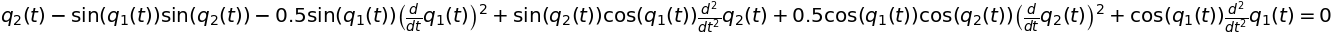

In [68]:
eqns[0]

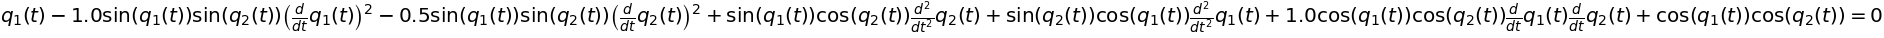

In [69]:
eqns[1]